Madoria-EDA

My analysis on the IMDB title.principals, title.ratings, and title.crew tables: 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

After importing, pandas and matplotlib, I decided to get a peek of all the tables including a description of each of the table values.

In [24]:
df= pd.read_csv('data/imdb.title.principals.csv')
df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [25]:
df2= pd.read_csv('data/imdb.title.ratings.csv')
df2.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [26]:
df3= pd.read_csv('data/imdb.title.crew.csv')
df3.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   tconst      1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   nconst      1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tconst     146144 non-null  object
 1   directors  140417 non-null  object
 2   writers    110261 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


The title.ratings (df2) didn't have too many nulls that I thought would interfere with my initial analysis, but title.principals(df) does. I decided to drop the 'job' and 'character' columns since so little of the information was filled out, so it's unlikely I'd use either one in the future. 

In [35]:
title_prinicipals = df.drop(['job', 'characters'], axis=1)
title_prinicipals.head()

,tconst,ordering,nconst,category
0,tt0111414,1,nm0246005,actor
1,tt0111414,2,nm0398271,director
2,tt0111414,3,nm3739909,producer
3,tt0323808,10,nm0059247,editor
4,tt0323808,1,nm3579312,actress


In [36]:
title_prinicipals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   tconst    1028186 non-null  object
 1   ordering  1028186 non-null  int64 
 2   nconst    1028186 non-null  object
 3   category  1028186 non-null  object
dtypes: int64(1), object(3)
memory usage: 31.4+ MB


In [33]:
title_prinicipals['ordering'].value_counts()

1     143454
2     134649
3     126538
4     117775
5     108862
6     100140
7      90820
8      80587
9      69218
10     56143
Name: ordering, dtype: int64

In [54]:
title_prinicipals['ordering'].groupby(['category'])

KeyError: 'category'

With that done, I decided to switch back to title.ratings(df2) and check out some of the descriptic statistics. Since we're looking for good movie studio recommendations, I'll use the mean to get a metric for the average rating. After that I decided to filter my results to only look at movies at or above the mean rating.

In [ ]:
df2.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [ ]:
title_ratings = df2[df2['averagerating'] >= 6.3]
title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         41856 non-null  object 
 1   averagerating  41856 non-null  float64
 2   numvotes       41856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


Text(0, 0.5, 'Number of Votes (per million)')

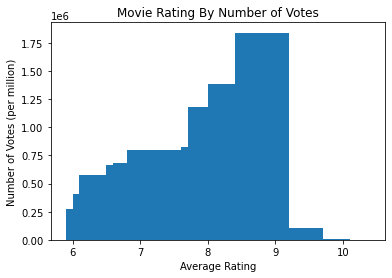

In [59]:
fig, ax = plt.subplots()

ax.bar(x=title_ratings['averagerating'], height=title_ratings['numvotes'])
ax.set_title("Movie Rating By Number of Votes")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of Votes")

In [44]:
print(f"This is the minimum # of votes per movie: {title_ratings['numvotes'].min()}")
print(f"This is the maximum # of votes per movie: {title_ratings['numvotes'].max()}")
print(f"This is the mean # of votes per movie: {title_ratings['numvotes'].mean()}")

This is the minimum # of votes per movie: 5
This is the maximum # of votes per movie: 1841066
This is the mean # of votes per movie: 4823.22594132263
